Visualizing convnet filters

https://github.com/himanshurawlani/convnet-interpretability-keras/blob/master/Visualizing%20filters/visualizing_convnet_filters.ipynb

- for the gradients and : https://www.sicara.ai/blog/2019-08-28-interpretability-deep-learning-tensorflow
https://gist.github.com/RaphaelMeudec/31b7bba0b972ec6ec80ed131a59c5b3f#file-kernel_visualization-py

- for building blocks instead of layers (better visualization) as blocks (conv + pooling)
together can capture structures: https://github.com/nikhilroxtomar/Custom-Blocks-in-TensorFlow-using-Keras-API/blob/main/cifar10.py


In [42]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras

In [43]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [44]:
base_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(50, 50, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [45]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [46]:
class ConvBlock(keras.Model):
    def __init__(self, num_filters, kernel_size=(3, 3), padding='same'):
        super(ConvBlock, self).__init__()

        self.conv = layers.Conv2D(num_filters, kernel_size, padding=padding)
        self.relu = layers.Activation("relu")
        self.pooling = layers.MaxPool2D((2, 2))
                

    def call(self, x):
        x = self.conv(x)
        x = self.pooling(x)
        x = self.relu(x)

        return x

In [47]:
def CNN_blocks(input_shape=(50, 50, 3), output_class_count=2):
            
    inputs = layers.Input(shape=input_shape,name='Input')

    x = base_model.get_layer('block1_conv1')(inputs)
    x.trainable=False

    x = base_model.get_layer('block1_conv2')(x)
    x.trainable=False


    x = ConvBlock(6, kernel_size=(5, 5))(x)

# layer 2   
    x= ConvBlock(16, kernel_size=(5, 5))(x)
    

# layer 3
    x = ConvBlock(120, kernel_size=(5, 5))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(84, activation='relu',name='F6')(x)
    outputs = layers.Dense(units=output_class_count,activation='softmax',name='Output')(x)

    model = keras.Model(inputs, outputs)
    return model

In [48]:
def CNN(input_shape=(50, 50, 3), output_class_count=2):
                
    inputs = layers.Input(shape=input_shape,name='Input')

    x = base_model.get_layer('block1_conv1')(inputs)
    x.trainable=False

    x = base_model.get_layer('block1_conv2')(x)
    x.trainable=False


    x = layers.Conv2D(filters=6, kernel_size=5, strides=1,padding='valid',name='conv1_1')(x)
   
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=2, strides=2,name='S1')(x)
    

# layer 2
    x = layers.Conv2D(filters=16, kernel_size=5,strides=1,padding='valid',name='conv2_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=2, strides=2,name='S2')(x)
    

# layer 3
    x = layers.Conv2D(filters=120, kernel_size=5,strides=1,padding='valid',name='conv3_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Flatten()(x)

    x = layers.Dropout(0.1)(x)
    x = layers.Dense(84, activation='relu',name='F6')(x)
    outputs = layers.Dense(units=output_class_count,activation='softmax',name='Output')(x)
    
    model = keras.Model(inputs, outputs)
    return model

In [57]:

model = CNN((50, 50, 3), 2)
model.load_weights('weights/CNN_weights.h5')

In [50]:
model.summary()

Model: "model_254"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 conv1_1 (Conv2D)            (None, 46, 46, 6)         9606      
                                                                 
 batch_normalization_3 (Batc  (None, 46, 46, 6)        24        
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 46, 46, 6)         0         
                                                         

In [51]:
for layer in model.layers:
    if 'conv' in layer.name:
        print(layer.name)
        print(len(layer.get_weights()))

block1_conv1
2
block1_conv2
2
conv1_1
2
conv2_1
2
conv3_1
2


In [52]:
l, b = model.get_layer('block1_conv1').get_weights()

In [53]:
l[0].shape

(3, 3, 64)

In [54]:
#f = model.get_layer('conv1').get_weights()

In [55]:
for layer in model.layers:
    if 'conv' in layer.name:
        filters, bias = layer.get_weights()
        print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
conv1_1 (5, 5, 64, 6)
conv2_1 (5, 5, 6, 16)
conv3_1 (5, 5, 16, 120)


Setting visualization variables

Maximize the activation of a specific filter

In [56]:
import numpy as np
import tensorflow as tf

# Layer name to inspect
layer_name = 'conv_block'

epochs = 100
step_size = 1.
filter_index = 5

# Create a connection between the input and the target layer

try: 
    submodel = tf.keras.models.Model([model.inputs[0]], [model.get_layer(layer_name).get_output_at(1)])
    
except:
    submodel = tf.keras.models.Model([model.inputs[0]], [model.get_layer(layer_name).output])

# Initiate random noise
input_img_data = np.random.random((1, 50, 50, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128.

# Cast random noise from np.float64 to tf.float32 Variable
input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

# Iterate gradient ascents
for _ in range(epochs):
    with tf.GradientTape() as tape:
        outputs = submodel(input_img_data)
        loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])
    grads = tape.gradient(loss_value, input_img_data)
    normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
    input_img_data.assign_add(normalized_grads * step_size)

ValueError: No such layer: conv_block. Existing layers are [<keras.engine.input_layer.InputLayer object at 0x7efcf00f6b80>, <keras.layers.convolutional.Conv2D object at 0x7efcb01952b0>, <keras.layers.convolutional.Conv2D object at 0x7efcb00ab6a0>, <keras.layers.convolutional.Conv2D object at 0x7efcf1a12520>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7efcf11bd130>, <keras.layers.advanced_activations.ReLU object at 0x7efcf273ea30>, <keras.layers.pooling.MaxPooling2D object at 0x7efcf00f6490>, <keras.layers.convolutional.Conv2D object at 0x7efcf563d490>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7efcb00cc400>, <keras.layers.advanced_activations.ReLU object at 0x7efce00b2a60>, <keras.layers.pooling.MaxPooling2D object at 0x7efcb01ee3a0>, <keras.layers.convolutional.Conv2D object at 0x7efcf00dc310>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7efcf00f61c0>, <keras.layers.advanced_activations.ReLU object at 0x7efcf00ea730>, <keras.layers.core.flatten.Flatten object at 0x7efcf00cc5e0>, <keras.layers.core.dropout.Dropout object at 0x7efcb072a8b0>, <keras.layers.core.dense.Dense object at 0x7efcb008fdc0>, <keras.layers.core.dense.Dense object at 0x7efcb01eedf0>].

In [ ]:
int(loss_value)

18576

In [ ]:
img = input_img_data.numpy().astype(np.uint8)
img = img.squeeze()
img = img / 255
img.max()
img.shape

(50, 50, 3)

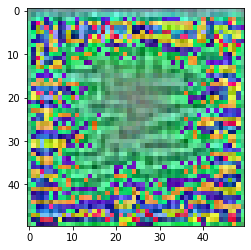

In [ ]:
plt.imshow(img, cmap='viridis')
plt.show()

In [ ]:
#dimensions of the generated pictures for each filter.
img_width = 50
img_height = 50

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
#layer_dict = dict([(layer.name, layer) for layer in model.layers[0:]])
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
layer_dict

{'block1_conv1': <keras.layers.convolutional.Conv2D at 0x7efce0092940>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x7efe3c251850>,
 'conv_block': <__main__.ConvBlock at 0x7efe3c272100>,
 'conv_block_1': <__main__.ConvBlock at 0x7efcf0079be0>,
 'conv_block_2': <__main__.ConvBlock at 0x7efce00a81c0>,
 'flatten_1': <keras.layers.core.flatten.Flatten at 0x7efcf0063a30>,
 'dropout_1': <keras.layers.core.dropout.Dropout at 0x7efce0049b80>,
 'F6': <keras.layers.core.dense.Dense at 0x7efce0340b50>,
 'Output': <keras.layers.core.dense.Dense at 0x7efce0092c40>}

In [ ]:
from keras import backend as K

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

In [ ]:
def build_nth_filter_loss(filter_index, layer_name):
    """
    We build a loss function that maximizes the activation
    of the nth filter of the layer considered
    """
    
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])
    # Initiate random noise
    # Create a connection between the input and the target layer
    
    try: 
        submodel = tf.keras.models.Model([model.inputs[0]], [model.get_layer(layer_name).get_output_at(1)])
    
    except:
        submodel = tf.keras.models.Model([model.inputs[0]], [model.get_layer(layer_name).output])


# Initiate random noise

    input_img_data = np.random.random((1, 50, 50, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128.

    # Cast random noise from np.float64 to tf.float32 Variable
    input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

    for _ in range(epochs):
        with tf.GradientTape() as tape:
            outputs = submodel(input_img_data)
            loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])
        grads = tape.gradient(loss_value, input_img_data)
        normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
        input_img_data.assign_add(normalized_grads * step_size)

    # this function returns the loss and grads given the input picture
    #iterate = K.function([input_img], [loss_value, grads])

    #if loss_value > 0:
    img = input_img_data.numpy().astype(np.float64)
    img = img.squeeze()
    img = deprocess_image(img)
    kept_filters.append((img, loss_value))
    #return iterate

In [ ]:
layers = [layer.name for layer in model.layers]

In [ ]:
import time

kept_filters = []
filters_dict = dict()
for layer_name in layers:
    if 'conv' in layer_name:
        layer = model.get_layer(layer_name)
        print('Processing filter for layer:', layer_name)
        for filter_index in range(min(layer.output.shape[-1], 100)):
            # print('Processing filter %d' % filter_index)

            start_time = time.time()
            build_nth_filter_loss(filter_index, layer_name)
            end_time = time.time()

    #         print('--->Filter %d processed in %ds' % (filter_index, end_time - start_time))
        filters_dict[layer.name] = kept_filters
        kept_filters = []

Processing filter for layer: block1_conv1
Processing filter for layer: block1_conv2
Processing filter for layer: conv_block
Processing filter for layer: conv_block_1
Processing filter for layer: conv_block_2


In [ ]:
for layer_name, kept_filters in filters_dict.items():
    print(layer_name, len(kept_filters))

block1_conv1 64
block1_conv2 64
conv_block 6
conv_block_1 16
conv_block_2 100


In [ ]:
from keras.preprocessing.image import save_img

def stich_filters(kept_filters, layer_name):
    # By default, we will stich the best 64 (n*n) filters on a 8 x 8 grid.
    n = int(np.sqrt(len(kept_filters)))
    # the filters that have the highest loss are assumed to be better-looking.
    # we will only keep the top 64 filters.
    kept_filters.sort(key=lambda x: x[1], reverse=True)
    kept_filters = kept_filters[:n * n]

    # build a black picture with enough space for
    # our 8 x 8 filters of size 128 x 128, with a 5px margin in between
    margin = 5
    width = n * img_width + (n - 1) * margin
    height = n * img_height + (n - 1) * margin
    stitched_filters = np.zeros((width, height, 3))

    # fill the picture with our saved filters
    for i in range(n):
        for j in range(n):
            img, loss = kept_filters[i * n + j]
            width_margin = (img_width + margin) * i
            height_margin = (img_height + margin) * j
            stitched_filters[
                width_margin: width_margin + img_width,
                height_margin: height_margin + img_height, :] = img

    # save the result to disk
    save_img('img/filters/stitched_filters_{}.png'.format(layer_name), stitched_filters)
    
for layer_name, kept_filters in filters_dict.items():
    print('Stiching filters for {}'.format(layer_name))
    stich_filters(kept_filters, layer_name)
    print('number of filters kept:', len(kept_filters))
    print('Completed.')

Stiching filters for block1_conv1
number of filters kept: 64
Completed.
Stiching filters for block1_conv2
number of filters kept: 64
Completed.
Stiching filters for conv_block
number of filters kept: 6
Completed.
Stiching filters for conv_block_1
number of filters kept: 16
Completed.
Stiching filters for conv_block_2
number of filters kept: 100
Completed.


In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

filter_name = 'conv3'

img = image.img_to_array(image.load_img('img/stitched_filters_{}.png'.format(filter_name))) /255.
plt.figure(figsize=(17,17))
plt.imshow(img)
plt.title(filter_name)
plt.grid(False)